# Chapter 3, RV Generation

## Part 1, Generation of uniform(0,1)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
np.random.uniform()

0.7989109364251646

pseudorandom numbers appear random but are actually from a deterministic sequence

In [3]:
np.random.uniform()

0.8173702199907823

Linear Congruential Generator. See: https://en.wikipedia.org/wiki/Linear_congruential_generator

Uniform (discrete on) $\{0,1,2,\ldots,2^{32}-1\}$

In [4]:
a = 1664525;
c = 1013904223;
m = 2**32;

$$
x_{n+1} = a x_n+c~~ \text{mod}~~ m
$$

Seed: $x_0$.

In [5]:
class LCG:
    def __init__(self, seed: int, a: int, c: int, m: int):
        self.X = seed
        self.a = a
        self.c = c
        self.m = m

    def next(self):
        self.X = (self.a * self.X + self.c) % self.m
        return self.X

    def random(self):
        return self.next()/self.m

In [6]:
lcg = LCG(seed = 42, a = 1664525, c = 1013904223, m = 2**32)

In [7]:
lcg.next()

1083814273

In [8]:
lcg.next()

378494188

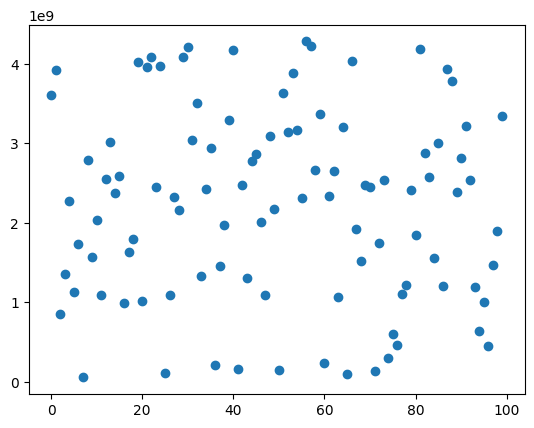

In [11]:
plt.scatter(range(100), [lcg.next() for _ in range(100)]);

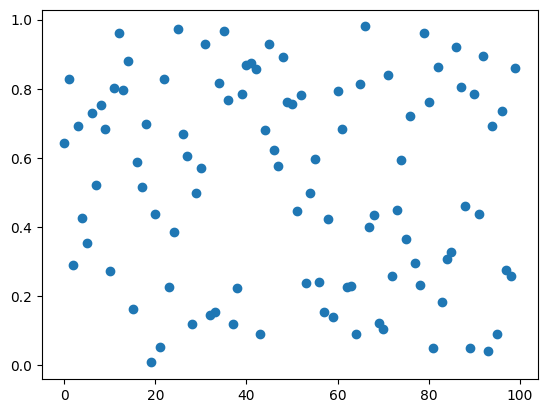

In [14]:
plt.scatter(range(100), [lcg.next()/(2**32) for _ in range(100)]);

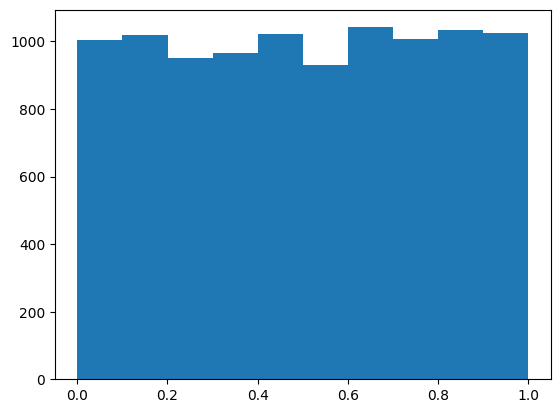

In [15]:
plt.hist([lcg.next()/(2**32) for _ in range(10**4)]);

## Part 2 (the main part), generation of everything else

## Inverse Probability Transform


You want to generate a random variable $X$ from a distribution that has CDF $F_X(x)$.

What you do is take $U \sim \text{uniform}(0,1)$.  And then you set $X = F_X^{-1}(U)$.

E.g. 

$$
F_X(x) = 
\begin{cases}
0 & \text{for}\quad x < 0\\
1-e^{-\lambda x} & \text{for} \quad x \ge 0
\end{cases}
$$

We saw before $F^{-1}_X(u) = -\frac{1}{\lambda}\log(1-u)$.  

In [26]:
def exp_rv(lam = 1.0):
    return -(1/lam)*math.log(lcg.random()) # did not do 1-lcg.random() because not needed

In [21]:
my_exps = [exp_rv() for _ in range(10**4)]

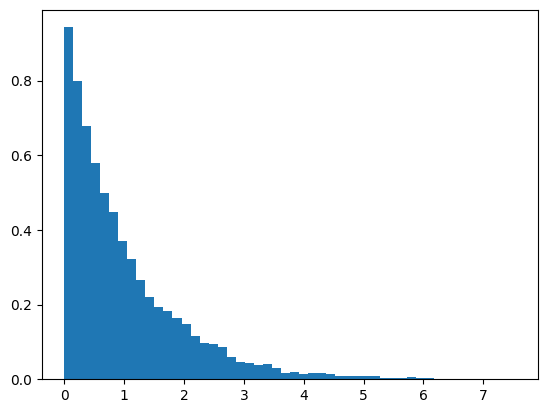

In [25]:
plt.hist(my_exps, bins = 50, density = True);